# Newton’s Method via JAX

# GPU

This lecture was built using a machine with JAX installed and access to a GPU.

To run this lecture on [Google Colab](https://colab.research.google.com/), click on the “play” icon top right, select Colab, and set the runtime environment to include a GPU.

To run this lecture on your own machine, you need to install [Google JAX](https://github.com/google/jax).

## Overview

One of the key features of JAX is automatic differentiation.

We introduced this feature in [Adventures with Autodiff](https://jax.quantecon.org/autodiff.html).

In this lecture we apply automatic differentiation to the problem of computing economic equilibria via Newton’s method.

Newton’s method is a relatively simple root and fixed point solution algorithm, which we discussed
in [a more elementary QuantEcon lecture](https://python.quantecon.org/newton_method.html).

JAX is ideally suited to implementing Newton’s method efficiently, even in high dimensions.

We use the following imports in this lecture

In [1]:
import jax
import jax.numpy as jnp
from scipy.optimize import root
import matplotlib.pyplot as plt

Let’s check the GPU we are running

In [2]:
!nvidia-smi

Sun Mar  9 14:11:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

牛顿法类似用泰勒展开近似 + 收敛速度很快（二次收敛），三五次就能得到解

## Newton in one dimension

As a warm up, let’s implement Newton’s method in JAX for a simple
one-dimensional root-finding problem.

Let $ f $ be a function from $ \mathbb R $ to itself.

A **root** of $ f $ is an $ x \in \mathbb R $ such that $ f(x)=0 $.

[Recall](https://python.quantecon.org/newton_method.html) that Newton’s method for solving for the root of $ f $ involves iterating with the map $ q $ defined by

$$
q(x) = x - \frac{f(x)}{f'(x)}
$$

Here is a function called `newton` that takes a function $ f $ plus a scalar value $ x_0 $,
iterates with $ q $ starting from $ x_0 $, and returns an approximate fixed point.

In [3]:
def newton(f, x_0, tol=1e-5):
    f_prime = jax.grad(f)
    def q(x):
        return x - f(x) / f_prime(x) #迭代法的解

    error = tol + 1
    x = x_0
    while error > tol:
        y = q(x)
        error = abs(x - y)
        x = y

    return x

The code above uses automatic differentiation to calculate $ f' $ via the call to `jax.grad`.

Let’s test our `newton` routine on the function shown below.

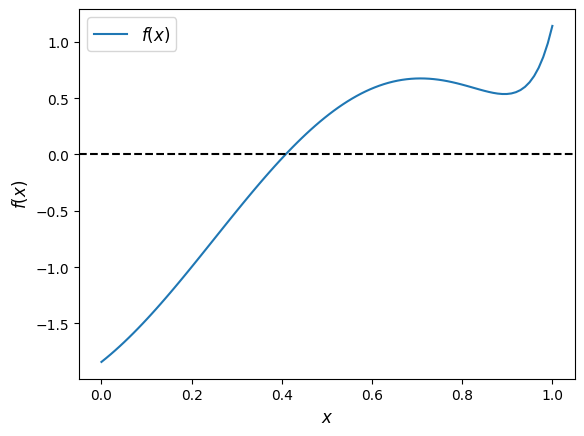

In [4]:
f = lambda x: jnp.sin(4 * (x - 1/4)) + x + x**20 - 1
x = jnp.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(x, f(x), label='$f(x)$')
ax.axhline(ls='--', c='k')
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$f(x)$', fontsize=12)
ax.legend(fontsize=12)
plt.show()

Here we go

In [5]:
newton(f, 0.2)

Array(0.4082935, dtype=float32, weak_type=True)

This number looks to be close to the root, given the figure.

## An Equilibrium Problem

Now let’s move up to higher dimensions.

First we describe a market equilibrium problem we will solve with JAX via root-finding.

The market is for $ n $ goods.

(We are extending a two-good version of the market from [an earlier lecture](https://python.quantecon.org/newton_method.html).)

The supply function for the $ i $-th good is

$$
q^s_i (p) = b_i \sqrt{p_i}
$$

which we write in vector form as

$$
q^s (p) =b \sqrt{p}
$$

(Here $ \sqrt{p} $ is the square root of each $ p_i $ and $ b \sqrt{p} $ is the vector
formed by taking the pointwise product $ b_i \sqrt{p_i} $ at each $ i $.)

The demand function is

$$
q^d (p) = \exp(- A p) + c
$$

(Here $ A $ is an $ n \times n $ matrix containing parameters, $ c $ is an $ n \times
1 $ vector and the $ \exp $ function acts pointwise (element-by-element) on the
vector $ - A p $.)

The excess demand function is

$$
e(p) = \exp(- A p) + c - b \sqrt{p}
$$

An **equilibrium price** vector is an $ n $-vector $ p $ such that $ e(p) = 0 $.

The function below calculates the excess demand for given parameters

In [6]:
def e(p, A, b, c):
    return jnp.exp(- A @ p) + c - b * jnp.sqrt(p)

## Computation

In this section we describe and then implement the solution method.

### Newton’s Method

We use a multivariate version of Newton’s method to compute the equilibrium price.

The rule for updating a guess $ p_n $ of the equilibrium price vector is


<a id='equation-multi-newton'></a>
$$
p_{n+1} = p_n - J_e(p_n)^{-1} e(p_n) \tag{4.1}
$$

Here $ J_e(p_n) $ is the Jacobian of $ e $ evaluated at $ p_n $.

Iteration starts from initial guess $ p_0 $.

Instead of coding the Jacobian by hand, we use automatic differentiation via `jax.jacobian()`.

In [7]:
def newton(f, x_0, tol=1e-5, max_iter=15):
    """
    A multivariate Newton root-finding routine.

    """
    x = x_0
    f_jac = jax.jacobian(f)
    @jax.jit
    def q(x):
        " Updates the current guess. "
        return x - jnp.linalg.solve(f_jac(x), f(x)) #就相当于是f(x)/f'(x),避免求inverse
    error = tol + 1
    n = 0
    while error > tol:
        n += 1
        if(n > max_iter):
            raise Exception('Max iteration reached without convergence')
        y = q(x)
        error = jnp.linalg.norm(x - y)
        x = y
        print(f'iteration {n}, error = {error}')
    return x

### Application

Let’s now apply the method just described to investigate a large market with 5,000 goods.

We randomly generate the matrix $ A $ and set the parameter vectors $ b, c $ to $ 1 $.

In [9]:
dim = 5_000  # 设定维度，即 5000 维市场
seed = 32  # 设定随机数种子，保证可复现

# Create a random matrix A and normalize the rows to sum to one
key = jax.random.PRNGKey(seed)
A = jax.random.uniform(key, [dim, dim])  # 生成 [0,1] 均匀分布的 5000x5000 矩阵

s = jnp.sum(A, axis=0)  # 计算每一列的总和
A = A / s  # 归一化，使得每一列的元素和为 1

# 设定 b 和 c 向量
b = jnp.ones(dim)  # 5000 维的全 1 向量
c = jnp.ones(dim)  # 5000 维的全 1 向量


Here’s our initial condition $ p_0 $

In [10]:
init_p = jnp.ones(dim)

By combining the power of Newton’s method, JAX accelerated linear algebra,
automatic differentiation, and a GPU, we obtain a relatively small error for
this high-dimensional problem in just a few seconds:

In [11]:
%%time
p = newton(lambda p: e(p, A, b, c), init_p).block_until_ready()

iteration 1, error = 29.977458953857422
iteration 2, error = 5.092828750610352
iteration 3, error = 0.10971637070178986
iteration 4, error = 5.167595372768119e-05
iteration 5, error = 1.1732883649528958e-05
iteration 6, error = 4.191016159893479e-06
CPU times: user 7.66 s, sys: 2 s, total: 9.66 s
Wall time: 10.6 s


We run it again to eliminate compile time.

In [12]:
%%time
p = newton(lambda p: e(p, A, b, c), init_p).block_until_ready()

iteration 1, error = 29.977458953857422
iteration 2, error = 5.092828750610352
iteration 3, error = 0.10971637070178986
iteration 4, error = 5.167595372768119e-05
iteration 5, error = 1.1732883649528958e-05
iteration 6, error = 4.191016159893479e-06
CPU times: user 3.04 s, sys: 1.93 s, total: 4.97 s
Wall time: 4.84 s


Here’s the size of the error:

In [13]:
jnp.max(jnp.abs(e(p, A, b, c)))

Array(1.1920929e-07, dtype=float32)

With the same tolerance, SciPy’s `root` function takes much longer to run,
even with the Jacobian supplied.

In [ ]:
%%time
solution = root(lambda p: e(p, A, b, c),
                init_p,
                jac=lambda p: jax.jacobian(e)(p, A, b, c),
                method='hybr',
                tol=1e-5)

solution = root(fun, x0, jac=jac_fun, method='hybr', tol=1e-5)

root() 主要用于 求解非线性方程组：

- fun=lambda p: e(p, A, b, c)：目标函数 e(p)，即超额需求函数。
- x0=init_p：初始价格向量 p0 。
- jac=lambda p: jax.jacobian(e)(p, A, b, c)：
计算 雅可比矩阵 J(p)，加快收敛速度。
- method='hybr'：
Hybrid Powell 方法，结合牛顿法与信赖域方法，提高收敛稳定性。
- tol=1e-5：
设定收敛阈值，即当误差小于 10**(−5)  时，认为找到均衡价格。

The result is also slightly less accurate:

In [ ]:
p = solution.x
jnp.max(jnp.abs(e(p, A, b, c)))

## Exercises

## Exercise 4.1

Consider a three-dimensional extension of [the Solow fixed point
problem](https://python.quantecon.org/newton_method.html#the-solow-model) with

$$
A = \begin{pmatrix}
            2 & 3 & 3 \\
            2 & 4 & 2 \\
            1 & 5 & 1 \\
        \end{pmatrix},
            \quad
s = 0.2, \quad α = 0.5, \quad δ = 0.8
$$

As before the law of motion is

$$
k_{t+1} = g(k_t) \quad \text{where} \quad
    g(k) := sAk^\alpha + (1-\delta) k
$$

However $ k_t $ is now a $ 3 \times 1 $ vector.

Solve for the fixed point using Newton’s method with the following initial values:

$$
\begin{aligned}
    k1_{0} &= (1, 1, 1) \\
    k2_{0} &= (3, 5, 5) \\
    k3_{0} &= (50, 50, 50)
\end{aligned}
$$

- The computation of the fixed point is equivalent to computing $ k^* $ such that $ f(k^*) - k^* = 0 $.  
- If you are unsure about your solution, you can start with the solved example:  


$$
A = \begin{pmatrix}
            2 & 0 & 0 \\
            0 & 2 & 0 \\
            0 & 0 & 2 \\
        \end{pmatrix}
$$

with $ s = 0.3 $, $ α = 0.3 $, and $ δ = 0.4 $ and starting value:

$$
k_0 = (1, 1, 1)
$$

The result should converge to the [analytical solution](https://python.quantecon.org/newton_method.html#solved-k).

## Solution to[ Exercise 4.1](https://jax.quantecon.org/#newton_ex1)

Let’s first define the parameters for this problem

In [14]:
A = jnp.array([[2.0, 3.0, 3.0],
               [2.0, 4.0, 2.0],
               [1.0, 5.0, 1.0]])
s = 0.2
α = 0.5
δ = 0.8
initLs = [jnp.ones(3),
          jnp.array([3.0, 5.0, 5.0]),
          jnp.repeat(50.0, 3)]

Then we define the multivariate version of the formula for the [law of motion of capital](https://python.quantecon.org/newton_method.html#solow)

In [15]:
def multivariate_solow(k, A=A, s=s, α=α, δ=δ):
    return s * jnp.dot(A, k**α) + (1 - δ) * k

Let’s run through each starting value and see the output

In [16]:
attempt = 1
for init in initLs:
    print(f'Attempt {attempt}: Starting value is {init} \n')
    %time k = newton(lambda k: multivariate_solow(k) - k, \
                     init).block_until_ready()
    print('-'*64)
    attempt += 1

Attempt 1: Starting value is [1. 1. 1.] 

iteration 1, error = 50.496315002441406
iteration 2, error = 41.1093864440918
iteration 3, error = 4.294127464294434
iteration 4, error = 0.3854290544986725
iteration 5, error = 0.0054382034577429295
iteration 6, error = 8.92080606718082e-07
CPU times: user 216 ms, sys: 17.2 ms, total: 233 ms
Wall time: 280 ms
----------------------------------------------------------------
Attempt 2: Starting value is [3. 5. 5.] 

iteration 1, error = 2.0701100826263428
iteration 2, error = 0.12642373144626617
iteration 3, error = 0.0006017307168804109
iteration 4, error = 3.3717478231665154e-07
CPU times: user 84.5 ms, sys: 4.97 ms, total: 89.4 ms
Wall time: 85.3 ms
----------------------------------------------------------------
Attempt 3: Starting value is [50. 50. 50.] 

iteration 1, error = 73.00942993164062
iteration 2, error = 6.493789196014404
iteration 3, error = 0.6806989312171936
iteration 4, error = 0.016202213242650032
iteration 5, error = 1.06009

We find that the results are invariant to the starting values.

But the number of iterations it takes to converge is dependent on the starting values.

Let substitute the output back into the formulate to check our last result

In [17]:
multivariate_solow(k) - k

Array([ 4.7683716e-07,  0.0000000e+00, -2.3841858e-07], dtype=float32)

Note the error is very small.

We can also test our results on the known solution

In [ ]:
A = jnp.array([[2.0, 0.0, 0.0],
               [0.0, 2.0, 0.0],
               [0.0, 0.0, 2.0]])
s = 0.3
α = 0.3
δ = 0.4
init = jnp.repeat(1.0, 3)
%time k = newton(lambda k: multivariate_solow(k, A=A, s=s, α=α, δ=δ) - k, \
                 init).block_until_ready()

In [ ]:
# Now we time it without compile
%time k = newton(lambda k: multivariate_solow(k, A=A, s=s, α=α, δ=δ) - k, \
                 init).block_until_ready()

The result is very close to the true solution but still slightly different.

We can increase the precision of the floating point numbers and restrict the tolerance to obtain a more accurate approximation (see detailed discussion in the [lecture on JAX](https://python-programming.quantecon.org/jax_intro.html#differences))

In [18]:
# We will use 64 bit floats with JAX in order to increase the precision.
jax.config.update("jax_enable_x64", True)
init = init.astype('float64')

%time k = newton(lambda k: multivariate_solow(k, A=A, s=s, α=α, δ=δ) - k,\
                 init, tol=1e-7).block_until_ready()

iteration 1, error = 73.00942865736772
iteration 2, error = 6.493790240268519
iteration 3, error = 0.6806981462275397
iteration 4, error = 0.01620284198001301
iteration 5, error = 1.01788625560847e-05
iteration 6, error = 4.02641276801186e-12
CPU times: user 196 ms, sys: 16.2 ms, total: 213 ms
Wall time: 359 ms


In [19]:
# Now we time it without compile
%time k = newton(lambda k: multivariate_solow(k, A=A, s=s, α=α, δ=δ) - k,\
                 init, tol=1e-7).block_until_ready()

iteration 1, error = 73.00942865736772
iteration 2, error = 6.493790240268519
iteration 3, error = 0.6806981462275397
iteration 4, error = 0.01620284198001301
iteration 5, error = 1.01788625560847e-05
iteration 6, error = 4.02641276801186e-12
CPU times: user 96.1 ms, sys: 8.81 ms, total: 105 ms
Wall time: 127 ms


We can see it steps towards a more accurate solution.

## Exercise 4.2

In this exercise, let’s try different initial values and check how Newton’s method responds to different starting points.

Let’s define a three-good problem with the following default values:

$$
A = \begin{pmatrix}
            0.2 & 0.1 & 0.7 \\
            0.3 & 0.2 & 0.5 \\
            0.1 & 0.8 & 0.1 \\
        \end{pmatrix},
            \qquad
b = \begin{pmatrix}
            1 \\
            1 \\
            1
        \end{pmatrix}
    \qquad \text{and} \qquad
c = \begin{pmatrix}
            1 \\
            1 \\
            1
        \end{pmatrix}
$$

For this exercise, use the following extreme price vectors as initial values:

$$
\begin{aligned}
    p1_{0} &= (5, 5, 5) \\
    p2_{0} &= (1, 1, 1) \\
    p3_{0} &= (4.5, 0.1, 4)
\end{aligned}
$$

Set the tolerance to $ 10^{-15} $ for more accurate output.

Similar to [exercise 1](#newton_ex1), enabling `float64` for JAX can improve the precision of our results.

## Solution to[ Exercise 4.2](https://jax.quantecon.org/#newton_ex2)

Define parameters and initial values

In [24]:
A = jnp.array([
    [0.2, 0.1, 0.7],
    [0.3, 0.2, 0.5],
    [0.1, 0.8, 0.1]
])
b = jnp.array([1.0, 1.0, 1.0])
c = jnp.array([1.0, 1.0, 1.0])
initLs = [jnp.repeat(5.0, 3),
          jnp.ones(3), #似乎一开始漏了这一行
          jnp.array([4.5, 0.1, 4.0])]

Let’s run through each initial guess and check the output

In [25]:
attempt = 1
for init in initLs:
    print(f'Attempt {attempt}: Starting value is {init} \n')
    init = init.astype('float64')
    %time p = newton(lambda p: e(p, A, b, c), \
                 init, \
                 tol=1e-15, max_iter=15).block_until_ready()
    print('-'*64)
    attempt +=1

Attempt 1: Starting value is [5. 5. 5.] 

iteration 1, error = 9.243805733085065
iteration 2, error = nan
CPU times: user 80.8 ms, sys: 6.29 ms, total: 87 ms
Wall time: 82.1 ms
----------------------------------------------------------------
Attempt 2: Starting value is [1. 1. 1.] 

iteration 1, error = 0.7341870920561572
iteration 2, error = 0.12472401422714874
iteration 3, error = 0.002686717504221668
iteration 4, error = 1.18807443206464e-06
iteration 5, error = 2.3229389251513455e-13
iteration 6, error = 7.364386412590295e-16
CPU times: user 78 ms, sys: 2.33 ms, total: 80.3 ms
Wall time: 75.2 ms
----------------------------------------------------------------
Attempt 3: Starting value is [4.5 0.1 4. ] 

iteration 1, error = 4.892018895185869
iteration 2, error = 1.2120550201694784
iteration 3, error = 0.6942087122866175
iteration 4, error = 0.168951089180319
iteration 5, error = 0.005209730313222213
iteration 6, error = 4.3632751705775364e-06
iteration 7, error = 3.0460818773540415

We can find that Newton’s method may fail for some starting values.

Sometimes it may take a few initial guesses to achieve convergence.

Substitute the result back to the formula to check our result

In [26]:
e(p, A, b, c)

Array([0., 0., 0.], dtype=float64)

We can see the result is very accurate.